## Sequence generations

### created by Yuying Liu, 06/10/2020

This script is a template for sequence generation with different neural network architectures, including our multiscale HiTS, LSTM, ESN and CW-RNN. We carefully choose the number of hidden units for each so that the amount of trainable parameters are close. The {model}\_pred.npy files are generated and will be further fed to other scripts for visualization.

In [1]:
# imports
import os
import sys
import torch
import numpy as np
import scipy as sp

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as resnet
import rnn
import esn
import cwrnn

In [2]:
path_to_KS = '../../data/KS/'

path_to_model = '../../models/'
path_to_result = '../../results/'

In [9]:
noise_level = 0.8
ks_data = np.load(os.path.join(path_to_KS, 'data_n{}.npy'.format(noise_level)))

print('KS data: ', ks_data.shape)

KS data:  (512, 4001)


In [10]:
# adjustable parameters

normalize = True                   # if to normalize the features 
data = ks_data.T                # choose the sequence you want to generate
print(data.shape)
model_prefix = 'KS'             # 'Fluid', 'Flower', 'KS' or 'Bach'
n_forward = 6                      # number of training steps
# archs = [[22, 256, 22], 
#          [22, 164, 22], 
#          [22, 16, 22], 
#          [22, 4, 22]]              # multscale HiTS architecture, details can be found in table 4
archs = [[512, 2048, 512], 
         [512, 1024 ,512], 
         [512, 512, 512], 
         [512, 256, 512], 
         [512, 128, 512]]
step_sizes = [1, 6, 36, 216, 1296]        # step sizes of HiTSs, details can be found in Appendix A.3
lr = 1e-3                          # learning rate
max_epoch = 10000                  # maximum number of epochs
batch_size = 100                   # training batch size

if normalize:
    mean_values = data.mean(0)
    ranges = data.ptp(0)
    data = (data - mean_values)/ranges

(4001, 512)


### coupled NNs

In [11]:
# dummy parameter
dt = 1  

print("model_predix = ", model_prefix)
# training
models = []
n_steps = data.shape[0] - 1  # number of forward steps
for (arch, step_size) in zip(archs, step_sizes):
    m = int(np.ceil(n_steps/(step_size*n_forward)))
    pdata = np.zeros((m, step_size*n_forward+1, data.shape[1]))
    for i in range(m):
        start_idx = i*step_size*n_forward
        end_idx = start_idx + step_size*n_forward + 1
        tmp = data[start_idx:end_idx, :]
        pdata[i, :tmp.shape[0], :] = tmp
    dataset = resnet.DataSet(pdata, pdata, data[np.newaxis, :], dt, step_size, n_forward)
    print('MODEL: '+model_prefix+'_D{}'.format(step_size))
    model = resnet.ResNet(arch=arch, dt=dt, step_size=step_size)
    model.train_net(dataset, max_epoch=max_epoch, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(path_to_model, model_prefix, model_prefix+'_D{}_n{}.pt'.format(step_size, noise_level)))
    models.append(model)

print('# of params: ', sum([sum(p.numel() for p in model.parameters() if p.requires_grad) for model in models]))

model_predix =  KS
MODEL: KS_D1
time for first 10 =  0.11660194396972656
epoch 1000, training loss 0.007570845540612936, validation loss 0.0075666154734790325
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.005897986702620983, validation loss 0.00588847603648901
(--> new model saved @ epoch 2000)
epoch 3000, training loss 0.004594145808368921, validation loss 0.004583260510116816
(--> new model saved @ epoch 3000)
epoch 4000, training loss 0.003804410807788372, validation loss 0.0037903916090726852
(--> new model saved @ epoch 4000)
epoch 5000, training loss 0.0032607782632112503, validation loss 0.003277010517194867
(--> new model saved @ epoch 5000)
epoch 6000, training loss 0.002882854314520955, validation loss 0.002844005124643445
(--> new model saved @ epoch 6000)
epoch 7000, training loss 0.0025475125294178724, validation loss 0.002587541937828064
(--> new model saved @ epoch 7000)
epoch 8000, training loss 0.002446339698508382, validation loss 0.002454403322190046

In [12]:
import scipy.interpolate
def vectorized_multi_scale_forecast(x_init, n_steps, models):
    """
    :param x_init: initial state torch array of shape n_test x n_dim
    :param n_steps: number of steps forward in terms of dt
    :param models: a list of models
    :return: a torch array of size n_test x n_steps x n_dim,
             a list of indices that are not achieved by interpolations
    """
    # sort models by their step sizes (decreasing order)
    step_sizes = [model.step_size for model in models]
    models = [model for _, model in sorted(zip(step_sizes, models), reverse=True)]

    # we assume models are sorted by their step sizes (decreasing order)
    n_test, n_dim = x_init.shape
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    indices = list()
    extended_n_steps = n_steps + models[0].step_size
    preds = torch.zeros(n_test, extended_n_steps + 1, n_dim).float().to(device)

    # vectorized simulation
    indices.append(0)
    preds[:, 0, :] = x_init
    total_step_sizes = n_steps
    for model in models:
        n_forward = int(total_step_sizes/model.step_size)
        y_prev = preds[:, indices, :].reshape(-1, n_dim)
        indices_lists = [indices]
        for t in range(n_forward):
            y_next = model(y_prev)
            shifted_indices = [x + (t + 1) * model.step_size for x in indices]
            indices_lists.append(shifted_indices)
            preds[:, shifted_indices, :] = y_next.reshape(n_test, -1, n_dim)
            y_prev = y_next
        indices = [val for tup in zip(*indices_lists) for val in tup]
        total_step_sizes = model.step_size - 1

    # simulate the tails
    last_idx = indices[-1]
    y_prev = preds[:, last_idx, :]
    while last_idx < n_steps:
        last_idx += models[-1].step_size
        y_next = models[-1](y_prev)
        preds[:, last_idx, :] = y_next
        indices.append(last_idx)
        y_prev = y_next

    # interpolations
    sample_steps = range(1, n_steps+1)
    valid_preds = preds[:, indices, :].cpu().detach().numpy()
    cs = scipy.interpolate.interp1d(indices, valid_preds, kind='linear', axis=1)
    y_preds = torch.tensor(cs(sample_steps)).float()

    return y_preds

In [13]:
models = []
for step_size in step_sizes:
    models.append(torch.load(os.path.join(path_to_model, model_prefix, model_prefix+'_D{}_n{}.pt'.format(step_size, noise_level))))
    
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

# dataset = resnet.DataSet(pdata, pdata, data[np.newaxis, :], dt, step_size, n_forward)
print(dataset.test_x.cpu().is_cuda)
y_preds = vectorized_multi_scale_forecast(dataset.test_x.cpu(), n_steps=n_steps, models=models[:-1])
# y_preds = torch.cat([dataset.test_x.unsqueeze(0).cpu(), y_preds], dim=1).squeeze().detach().numpy()

if normalize:
    y_preds = y_preds * ranges + mean_values
# np.save(os.path.join(path_to_result, model_prefix, model_prefix + '_couple_pred.npy', y_preds))

False


torch.Size([4000, 512])


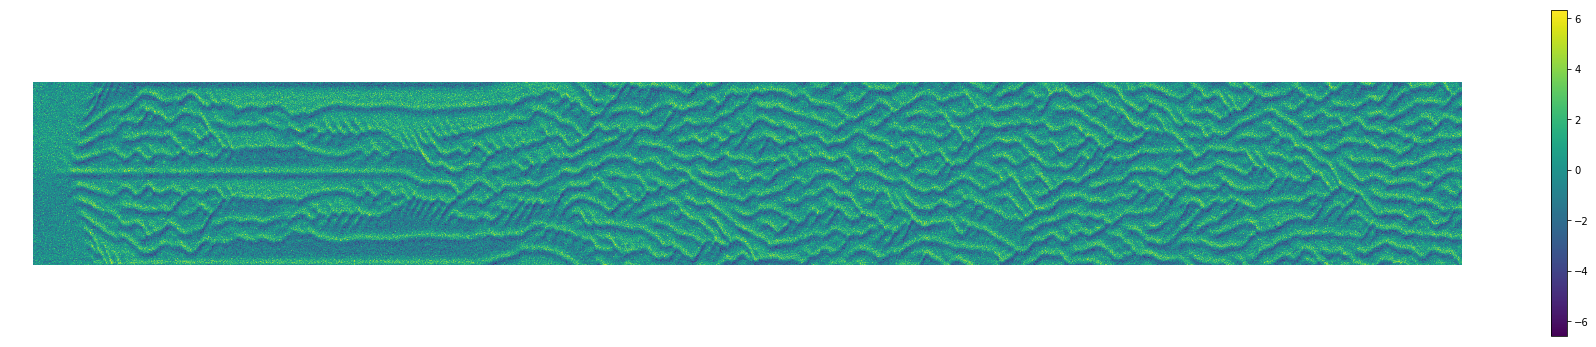

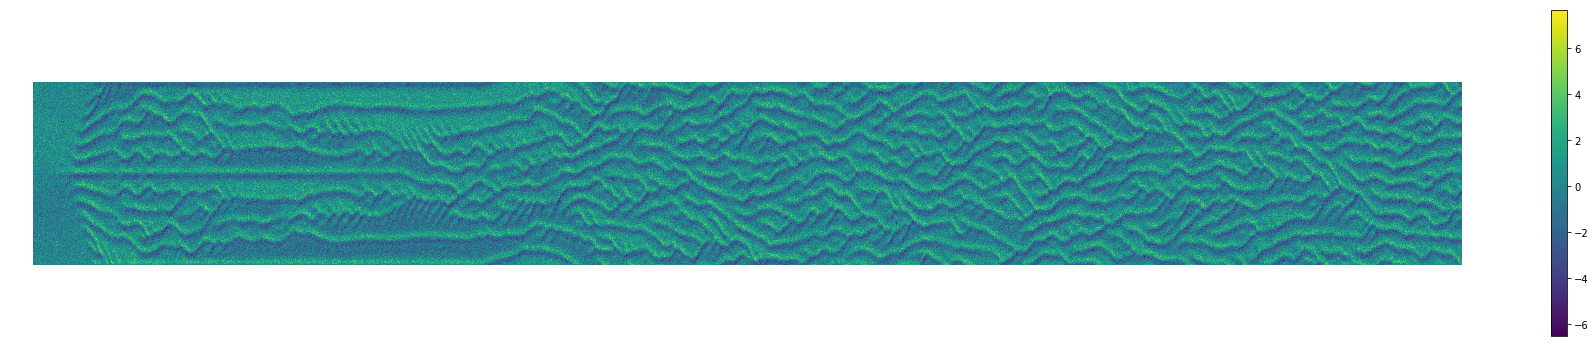

[0.18782115 0.17871486 0.19446133 ... 0.22725923 0.28588755 0.36896652]


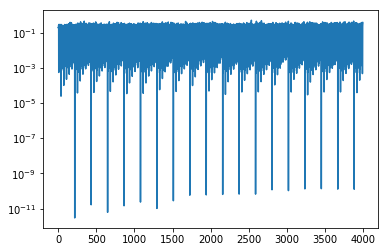

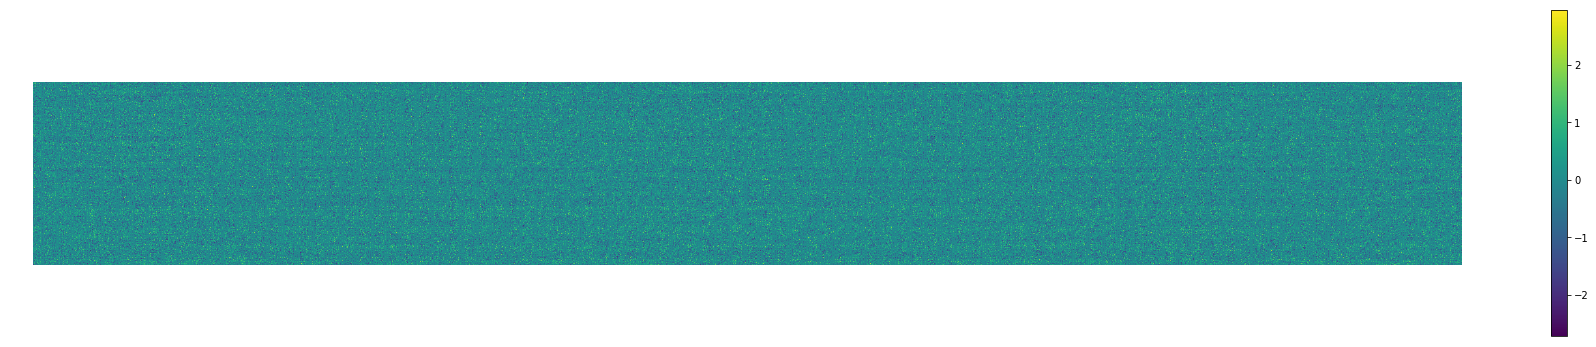

In [15]:
print(y_preds.squeeze(0).shape)
plt.figure(figsize=(32, 6))
plt.axis('off')
plt.imshow(y_preds.squeeze(0).T)
plt.colorbar()
plt.show()

plt.figure(figsize=(32, 6))
plt.axis('off')
plt.imshow(ks_data)
plt.colorbar()
plt.show()

#finding mse

mse = np.mean((ks_data[:,1:] - y_preds.squeeze(0).T.detach().numpy())**2, axis = 0)
print(mse)
plt.semilogy(mse)
plt.show()

plt.figure(figsize=(32, 6))
plt.axis('off')
plt.imshow(ks_data[:,1:] - y_preds.squeeze(0).T.detach().numpy())
plt.colorbar()
plt.show()



302


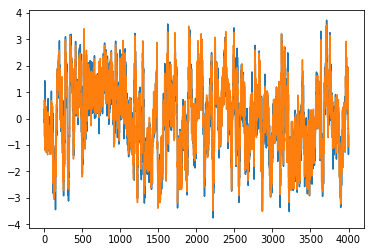

In [66]:
idx = np.random.randint(len(ks_data))
print(idx)
# print(y_preds.shape)
plt.plot(ks_data[idx])
plt.plot(y_preds[0,:,idx])

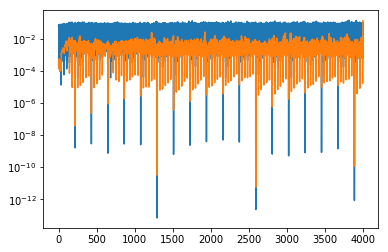

In [65]:
mse_noise = mse


plt.semilogy(mse_noise)
plt.semilogy(mse_no_noise)

### lstm

In [ ]:
# choose the hidden size so that # of parameters match 
model = rnn.LSTMWrapper(data.shape[-1], 740)
print('# of params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

# training
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch = 0
best_loss = 1e+5
while epoch < max_epoch:
    epoch += 1
    preds = model(torch.tensor(data[np.newaxis, :-1, :]).float())
    loss = criterion(preds, torch.tensor(data[np.newaxis, 1:, :]).float())
    if best_loss <= 1e-8:
        print('--> model has reached an accuracy of 1e-8! Finished training!')
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print('epoch {}, training loss {}'.format(epoch, loss.item()))
        if loss.item() < best_loss:
            best_loss = loss.item()
            print('(--> new model saved @ epoch {})'.format(epoch))
            torch.save(model, os.path.join(path_to_model, model_predix, model_prefix+'_lstm.pt'))

In [ ]:
model = torch.load(os.path.join(path_to_model, model_predix, model_prefix+'_lstm.pt'))
y_init = torch.tensor(data[np.newaxis, [0], :]).float()
y_preds = model(y_init, t=data.shape[0]-1)
y_preds = torch.cat([y_init, y_preds], dim=1).squeeze().detach().numpy()
if normalize:
    y_preds = y_preds * ranges + mean_values
np.save(os.path.join(path_to_result, model_prefix, model_prefix + '_lstm_pred.npy', y_preds))

### reservoir computing

In [ ]:
# choose the hidden size so that # of parameters match 
model = esn.ESN(data.shape[1], 1600)
y_pred = model(torch.tensor(data[:-1, :]).float())
truth = torch.tensor(data[1:, :]).float()
W_out = y_pred.pinverse() @ truth
print('# of params: ', W_out.shape[0]*W_out.shape[1])

In [ ]:
y_preds = torch.zeros(data.shape)
y_preds[0, :] = torch.tensor(data[0, :]).float()

h_pred = model.f(model.W_in @torch.tensor(data[0, :]).float())
y_pred = torch.matmul(h_pred, W_out)
y_preds[1, :] = y_pred
for t in range(2, data.shape[0]):
    h_pred = model.f(model.W_in @ y_pred + model.W_hat @ h_pred)
    y_pred = torch.matmul(h_pred, W_out)
    y_preds[t, :] = y_pred
    
y_preds = y_preds.detach().numpy()
if normalize:
    y_preds = y_preds * ranges + mean_values
np.save(os.path.join(path_to_result, model_prefix, model_prefix + '_reservoir_pred.npy', y_preds))

### cw-rnn

In [ ]:
# choose the hidden size so that # of parameters match 
model = cwrnn.CwRNN(data.shape[-1], 1570, 5)
print('# of params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

# training
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch = 0
best_loss = 1e+5
while epoch < max_epoch:
    epoch += 1
    preds = model(torch.tensor(data[np.newaxis, :-1, :]).float())
    loss = criterion(preds, torch.tensor(data[np.newaxis, 1:, :]).float())
    if best_loss <= 1e-8:
        print('--> model has reached an accuracy of 1e-8! Finished training!')
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print('epoch {}, training loss {}'.format(epoch, loss.item()))
        if loss.item() < best_loss:
            best_loss = loss.item()
            print('(--> new model saved @ epoch {})'.format(epoch))
            torch.save(model, os.path.join(path_to_model, model_predix, model_prefix+'_cwrnn.pt'))

In [ ]:
model = torch.load(os.path.join(path_to_model, model_predix, model_prefix+'_cwrnn.pt'))
y_preds = model.forecast(torch.tensor(data[[0], :]).float(), data.shape[0]-1)
y_preds = torch.cat([torch.tensor(data[[0], :]).float(), y_preds.squeeze()], dim=0).detach().numpy()
if normalize:
    y_preds = y_preds * ranges + mean_values
np.save(os.path.join(path_to_result, model_prefix, model_prefix + '_cwrnn_pred.npy', y_preds))